WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Index(['educ_center',
       'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)',
       'harass5_No', 'harass5_Yes', 'polviews_Conservative',
       'polviews_Extremely_liberal', 'polviews_Extrmly_conservative',
       'polviews_Liberal', 'polviews_Moderate',
       'polviews_Slghtly_conservative', 'polviews_Slightly_liberal',
       'advfront_Agree', 'advfront_Disagree', 'advfront_Dont_know',
       'advfront_Strongly_agree', 'advfront_Strongly_disagree', 'snapchat_No',
       'snapchat_Yes', 'instagrm_No', 'instagrm_Yes', 'wrkstat_Keeping_house',
       'wrkstat_Other', 'wrkstat_Retired', 'wrkstat_School',
       'wrkstat_Temp_not_working', 'wrkstat_Unempl,_laid_off',
       'wrkstat_Working_fulltime', 'wrkstat_Working_parttime'],
      dtype='object')
       Formula: email_time_center ~ educ_center + wrkstat_Working_fulltime
        Family: gamma
          Link: mu = log
  Observations: 1236
        Priors: 
    target = mu
        Common-level effects
            Int

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [email_time_center_alpha, Intercept, educ_center, wrkstat_Working_fulltime]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4507 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   
Intercept                -4.318  0.172  -4.631   -4.004      0.003    0.002  \
educ_center               1.679  0.255   1.229    2.176      0.005    0.003   
wrkstat_Working_fulltime  0.795  0.073   0.663    0.942      0.001    0.001   
email_time_center_alpha   0.579  0.019   0.540    0.613      0.000    0.000   

                          ess_bulk  ess_tail  r_hat  
Intercept                   3086.0    1601.0    1.0  
educ_center                 2917.0    1406.0    1.0  
wrkstat_Working_fulltime    3300.0    1461.0    1.0  
email_time_center_alpha     3483.0    1696.0    1.0  
<xarray.Dataset>
Dimensions:                   (chain: 2, draw: 1000, email_time_center_obs: 413)
Coordinates:
  * chain                     (chain) int32 0 1
  * draw                      (draw) int32 0 1 2 3 4 5 ... 995 996 997 998 999
  * email_time_center_obs     (email_time_center_obs) int32 0 1 2 ... 411 412
Data variables:
  

'\nX_train["email_time_center"] = pd.Series(y_train)\nX_train["log_email_time_center"] = X_train["email_time_center"].apply(lambda x: log(x, 10))\nX_train_fulltime = X_train[X_train["wrkstat_Working_fulltime"] == 1]\nX_train_not_fulltime = X_train[X_train["wrkstat_Working_fulltime"] == 0]\nsns.scatterplot(data=X_train_fulltime, y="log_email_time_center", x="educ_center", hue="wrkstat_Working_fulltime")\nplt.show()\nsns.scatterplot(data=X_train_not_fulltime, y="log_email_time_center", x="educ_center", hue="wrkstat_Working_fulltime")\nplt.show()\n'

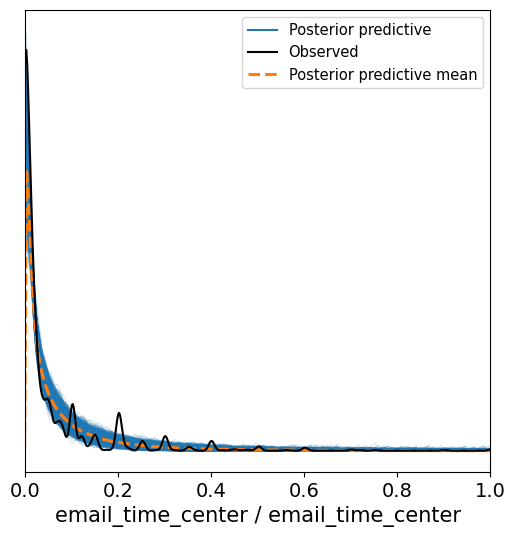

In [2]:
from math import log
import re
import bambi as bmb
from matplotlib import pyplot as plt
import pandas as pd
import arviz as az
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns

def final_model(X_train, y_train, X_test, y_test, features, seed: int):
    X_train["email_time_center"] = pd.Series(y_train)
    X_test["email_time_center"] = pd.Series(y_test)
    model = bmb.Model(
        """email_time_center ~ educ_center + wrkstat_Working_fulltime""",
        X_train, dropna=True, family="gamma", link="log")
    print(model)

    _, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6))
    ax.set_xlim(xmin=0, xmax=1)
    ax.set_ylim(ymin=0, ymax=1)
    
    results = model.fit(draws=1000, chains=2)
    print(az.summary(results))

    # Diagnostics
    model.predict(results, data=X_test, kind="pps")
    az.plot_ppc(results, ax=ax)
    
    # predict
    model.predict(results, data=X_test, kind="mean")
    print(results.posterior)
    y_predict = np.array(results.posterior.email_time_center_mean[0, 0, :])
    print(y_predict.shape)
    
    mse = mean_squared_error(y_test, y_predict)
    rmse = mean_squared_error(y_test, y_predict, squared=False)
    print(f"Test MSE: {mse}")
    print(f"Test RMSE: {rmse}")

feature_choice = [
    ["wrkstat_Working_fulltime", "educ_center", "polviews_Conservative"]
]
X = pd.read_csv("data/preprocessing/X.csv")
y = pd.read_csv("data/preprocessing/y.csv")["email_time_center"].apply(lambda x: x+0.001)
f = lambda x: re.sub(' ','_', x, flags = re.IGNORECASE)
X.rename(columns = f, inplace = True)
print(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
for index, choice in enumerate(feature_choice):
    final_model(X_train, y_train, X_test, y_test, choice, index)

"""
X_train["email_time_center"] = pd.Series(y_train)
X_train["log_email_time_center"] = X_train["email_time_center"].apply(lambda x: log(x, 10))
X_train_fulltime = X_train[X_train["wrkstat_Working_fulltime"] == 1]
X_train_not_fulltime = X_train[X_train["wrkstat_Working_fulltime"] == 0]
sns.scatterplot(data=X_train_fulltime, y="log_email_time_center", x="educ_center", hue="wrkstat_Working_fulltime")
plt.show()
sns.scatterplot(data=X_train_not_fulltime, y="log_email_time_center", x="educ_center", hue="wrkstat_Working_fulltime")
plt.show()
"""